In [1]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime

In [2]:
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

In [3]:
# Define the programs
# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, 2, instrument="CORALIE")
prog703 = Program(703, 13, instrument="CORALIE")
prog708 = Program(708, 7, instrument="CORALIE")
prog714 = Program(714, 2, instrument="CORALIE")

In [4]:
start_datetime = Time("2023-10-20 01:00:00")


In [5]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()

night = Night(start_datetime.datetime.date() - timedelta(days=1))

## Define a target and add merits

In [6]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.5})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto", parameters={'which':'nautical'})
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")

Targets from 708

In [7]:
# Test targets for the night of 2023-10-20
test_targets = ['HD224953A', 'CD-3931', 'CD-33501', 'BD-21397', 'HD16157',
                'CD-231056', 'CD-341770', 'HD32965', 'HD35650', 'HD274919',
                'BD-221344', 'CD-492340A', 'CD-422626', 'HD51199B', 'BD-141750',
                'BD-191855', 'HD58760', 'CD-363646', 'HD66020',
                'CD-81812', 'HD214100', 'HD218294']

# Create the targets
targets_708 = []
for tar_name in tqdm(test_targets):
    last_obs = start_datetime-5*u.day
    target = Target(tar_name, prog708, coords=SkyCoord.from_name(tar_name), last_obs=last_obs)
    target.add_merit(cadence_merit)
    # target.add_merit(airmass_merit)
    target.add_merit(culmination_merit)
    target.add_merit(egress_merit)
    target.add_merit(altitude_merit)
    target.add_merit(at_night_merit)
    targets_708.append(target)

  0%|          | 0/22 [00:00<?, ?it/s]

In [8]:
len(test_targets)

22

In [9]:
print(targets_708[4])

Target(Name: {self.name},
       Program: 708,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (38.59402579, -43.79635253)>,
       Last observation: 2023-10-15 01:00:00.000,
       Merits: [Merit(Cadence, efficiency), Merit(Culmination, efficiency), Merit(Egress, efficiency), Merit(Altitude, veto), Merit(AtNight, veto)],
       Time share allocated: 7,
       Time share current: 0.0,
       Time share pct diff: 0.0)


Targets from 714

In [10]:
# Load targets from 714 vthat are observable on the 20th of October 2023
cor714 = pd.read_csv("Prog714COR_priorP3_2023-10-20.csv", skiprows=1, sep="\t")
cor714.head()

,catalog name,SIMBAD id,DACE name,coordinates (DACE),cadence [d],days overdue,cadence percentage overdue [%],comments for the observer
0,HD27256,* alf Ret,HIP19780,4:14:25.5 / -62:28:26,360.0,6.0,1.7,NaN
1,HD38042,HD 38042,HIP26589,5:39:07.0 / -58:57:27,20.0,4.0,20.0,NaN
2,HD63295,* zet Vol,HIP37504,7:41:49.3 / -72:36:22,180.0,79.2,44.0,NaN
3,HD63744,* Q Pup,HIP38089,7:48:20.2 / -47:04:40,180.0,79.2,44.0,NaN
4,HD65638,HD 65638,HIP38925,7:57:54.8 / -40:47:04,180.0,79.2,44.0,NaN


In [11]:
targets_714 = []
for i, tar in cor714.iterrows():
    last_obs = start_datetime-5*u.day
    tar_coords = tar['coordinates (DACE)'].split(" / ")
    skycoord = SkyCoord(tar_coords[0], tar_coords[1], unit=(u.hourangle, u.deg))
    target = Target(tar['catalog name'], prog714, coords=skycoord, last_obs=last_obs)
    target.add_merit(cadence_merit)
    # target.add_merit(airmass_merit)
    target.add_merit(culmination_merit)
    target.add_merit(egress_merit)
    target.add_merit(altitude_merit)
    target.add_merit(at_night_merit)
    targets_714.append(target)

### Build the observations

In [12]:
# Merge the two programs
targets_all = targets_708 + targets_714

In [13]:
# test_observtions = [Observation(target, 
#                                 start_time=night.astronomical_evening, 
#                                 exposure_time=TimeDelta(15*u.min), 
#                                 night=night) for target in targets_all]
exp_time = TimeDelta(15*u.min)
test_observtions = [Observation(target, 
                                start_time=start_datetime, 
                                exposure_time=exp_time, 
                                night=night) for target in targets_all]

## Test the merits

In [14]:
test_obs = test_observtions[0]
print(f"Cadence merit = {cadence_merit.evaluate(test_obs)}")

Cadence merit = 0.816227766016838


In [15]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs, verbose=True)}")

Airmasses: [1.35248646 1.35044721 1.34844185 1.34647019 1.34453207 1.34262734
 1.34075583 1.33891738 1.33711185 1.33533909]
Max airmass: 1.3524864605751667
Airmass within limits, return merit.
Airmass merit = 0.7393789358709986


In [16]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = 1.0


In [17]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 47.67853727913631
Max altitude: 51.10576144784111
Min altitude: 25.596559288406713
Altitude proportion: 0.8656475358466956
Culmination merit = 0.8656475358466956


In [18]:
print(f"Egress merit = {egress_merit.evaluate(test_obs, verbose=True)}")

Current time: 2023-10-20 01:00:00.000
First time: 2460237.315169339
Last time: 2460237.925198847
Observable range proportion: 0.3712891338327911
Egress merit = 0.3712891338327911


In [19]:
test_obs.evaluate_score(verbose=True)

Fairness: 1
Sensibility: 1.0
Efficiency: 0.6843881452321082
Rank score: 0.6843881452321082


0.6843881452321082

# Test the Schedulers

In [20]:
# remove test_obs from the list
# test_observtions.remove(test_obs)

## Simple greedy search

In [21]:
# Create the plan
# plan = scheduler.forwardP(test_obs, test_observtions, 15)
plan = scheduler.forwardP(start_datetime, test_observtions, 25)

In [22]:
# print(plan)

In [23]:
plan.evaluate_plan()

0.5340242876016436

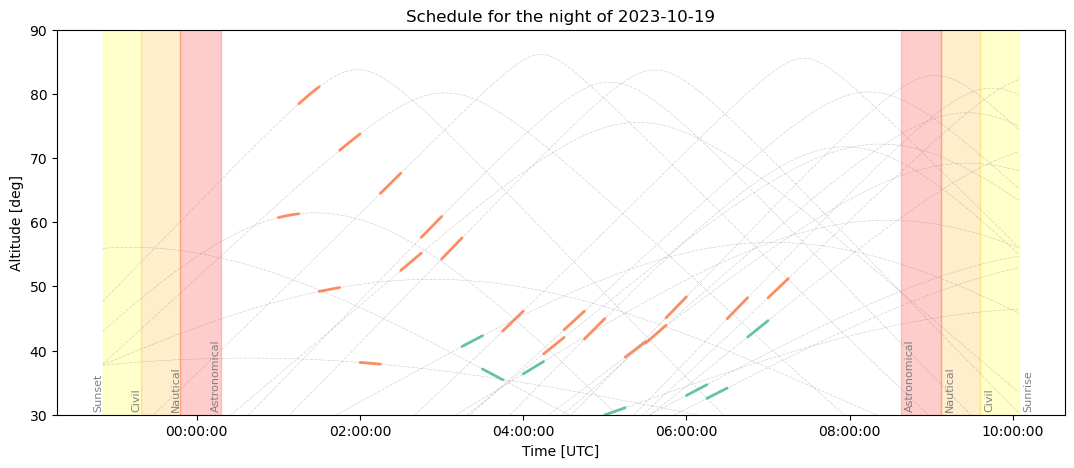

In [24]:
plan.plot()

## Recursive Dynamic Programming

In [25]:
# Create new list of targets without the egress merit
# By taking the current list of targets and removing the egress merit
targets_noegress = []
for target in targets_all:
    target_noegress = Target(target.name, target.program, coords=target.coords, last_obs=target.last_obs)
    target_noegress.add_merit(cadence_merit)
    target_noegress.add_merit(culmination_merit)
    target_noegress.add_merit(altitude_merit)
    target_noegress.add_merit(at_night_merit)
    targets_noegress.append(target_noegress)

# Create the new observations with the new targets
test_observtions_noegress = [Observation(target, 
                                         start_time=start_datetime, 
                                         exposure_time=TimeDelta(15*u.min), 
                                         night=night) for target in targets_noegress]

In [26]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observtions_noegress, 
#                                 Plan(), 
#                                 max_plan_length=10,
#                                 K = 4)

In [27]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [28]:
# dpplan[1].plot()

## Beam Search

In [29]:
beamsearch = scheduler.BeamSearchPlanner()

bs_plan = beamsearch.dp_beam_search(test_observtions_noegress, 
                                    max_plan_length=25, 
                                    K=3)

Went through the 0 level
Went through the 1 level
Went through the 2 level
Went through the 3 level
Went through the 4 level
Went through the 5 level
Went through the 6 level
Went through the 7 level
Went through the 8 level
Went through the 9 level
Went through the 10 level
Went through the 11 level
Went through the 12 level
Went through the 13 level
Went through the 14 level
Went through the 15 level
Went through the 16 level
Went through the 17 level
Went through the 18 level
Went through the 19 level
Went through the 20 level
Went through the 21 level
Went through the 22 level
Went through the 23 level
Went through the 24 level


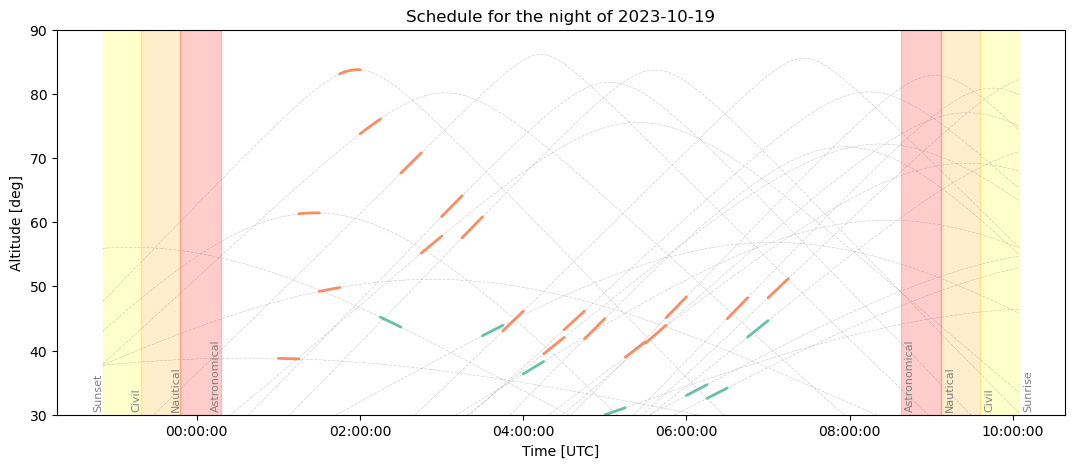

In [30]:
bs_plan.plot()

In [31]:
bs_plan.evaluate_plan()

0.7064115114731099